<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Compensation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box
from functools import partial 
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits import mplot3d
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
#@title Inverse { display-mode: "form" }
def inverse(f):

  def inverse_fn(q):
    
    def closure(p, q):
      return (f(p)-q)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), q)
    return res.params

  return inverse_fn

In [150]:
def output_fn(effort_fn, key, effort):
  return jnp.maximum(effort_fn(effort) + .5*jax.random.normal(key), 0.) 

def parameterized_effort_fn(param):
  return lambda x: param*x

def parameterized_cost_effort_fn(param):
  return lambda x: -1*param*x**2  

def parameterized_utility_fn(param):
  return lambda x: x**param 

def parameterized_wage_fn(a, b):
  return lambda x: a + b*x 

In [151]:
def monetary_value_from_effort(output_fn, effort_fn, cost_effort_fn, utility_fn, wage_fn, effort):
  keys = jax.random.split(jax.random.PRNGKey(0), 1000)
  effort_to_wage = lambda key: wage_fn(output_fn(effort_fn, key, effort))
  wages = jax.vmap(effort_to_wage)(keys)
  utils_from_wages = jax.vmap(utility_fn)(wages)
  utils_from_effort = cost_effort_fn(effort)
  total_utils = utils_from_wages + utils_from_effort
  avg_utils = jnp.mean(total_utils) 
  return  inverse(utility_fn)(avg_utils)

In [152]:
effort_fn = parameterized_effort_fn(2.)
cost_effort_fn = parameterized_cost_effort_fn(1.)
utility_fn = parameterized_utility_fn(0.5)

mvfe = partial(monetary_value_from_effort, output_fn, effort_fn, cost_effort_fn, utility_fn)

In [153]:
def optimal_effort(mvfe, wage_params):
  
  def closure(e, wage_params):
    wf = parameterized_wage_fn(*wage_params)
    return -1.0*mvfe(wf, e)
  solver = ProjectedGradient(fun=closure, projection=projection_box, maxiter=2000)
  res = solver.run(jnp.ones(shape=()), hyperparams_proj = (0., 1.), wage_params=wage_params)
  return res.params

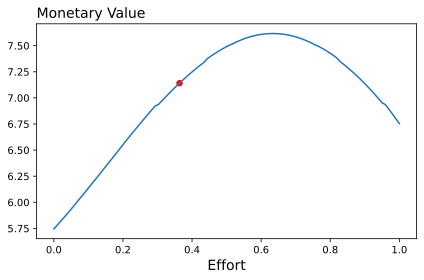

In [154]:
wage_params = (5., 4.)
es = jnp.linspace(0,1, 100)
ys = jax.vmap(partial(mvfe, parameterized_wage_fn(*wage_params)))(es)
fig = plt.figure(dpi=300, tight_layout=True)
e_opt = optimal_effort(mvfe, (5., 2.))
plt.scatter(e_opt, mvfe(parameterized_wage_fn(*wage_params), e_opt), s=30, color='red')
plt.plot(es,ys)
plt.title("Monetary Value", loc='left', size=14)
plt.xlabel('Effort', size=14)
fig.savefig('monetary_value.png', format='png')
plt.show()

In [157]:
marginal_wages = jnp.linspace(0., 4., 10)
optimal_efforts = jnp.array([optimal_effort(mvfe, (5., i)) for i in marginal_wages])

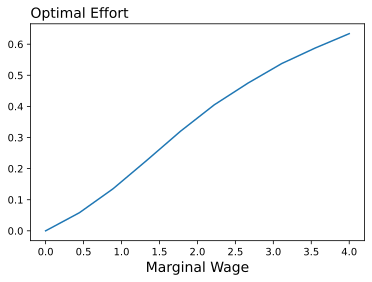

In [159]:
plt.plot(marginal_wages, optimal_efforts)
plt.title('Optimal Effort', loc='left', size=14)
plt.xlabel('Marginal Wage', size=14)
plt.show()